In [1]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext
sc= SparkContext()
sqlContext = SQLContext(sc)

house_df = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('boston.csv')
house_df.take(1)

[Row(CRIM=0.00632, ZN=18.0, INDUS=2.309999943, CHAS=0, NOX=0.537999988, RM=6.574999809, AGE=65.19999695, DIS=4.090000153, RAD=1, TAX=296, PT=15.30000019, B=396.8999939, LSTAT=4.980000019, MV=24.0)]

In [2]:
house_df.cache()
house_df.printSchema()

root
 |-- CRIM: double (nullable = true)
 |-- ZN: double (nullable = true)
 |-- INDUS: double (nullable = true)
 |-- CHAS: integer (nullable = true)
 |-- NOX: double (nullable = true)
 |-- RM: double (nullable = true)
 |-- AGE: double (nullable = true)
 |-- DIS: double (nullable = true)
 |-- RAD: integer (nullable = true)
 |-- TAX: integer (nullable = true)
 |-- PT: double (nullable = true)
 |-- B: double (nullable = true)
 |-- LSTAT: double (nullable = true)
 |-- MV: double (nullable = true)



In [3]:
house_df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
CRIM,506,3.6135235608162057,8.601545086715594,0.00632,88.97619629
ZN,506,11.363636363636363,23.32245299451514,0.0,100.0
INDUS,506,11.136778749531626,6.86035298095724,0.460000008,27.73999977
CHAS,506,0.0691699604743083,0.2539940413404101,0,1
NOX,506,0.5546950602312246,0.1158776754570543,0.38499999,0.870999992
RM,506,6.28463438896641,0.7026171549511354,3.561000109,8.779999733
AGE,506,68.57490120115612,28.148861532793276,2.900000095,100.0
DIS,506,3.7950426960059325,2.105710142043288,1.129600048,12.12650013
RAD,506,9.549407114624506,8.707259384239366,1,24


In [4]:
import six
for i in house_df.columns:
    if not( isinstance(house_df.select(i).take(1)[0][0], six.string_types)):
        print( "Correlation to MV for ", i, house_df.stat.corr('MV',i))

Correlation to MV for  CRIM -0.3883046116575088
Correlation to MV for  ZN 0.36044534463752903
Correlation to MV for  INDUS -0.48372517128143383
Correlation to MV for  CHAS 0.17526017775291847
Correlation to MV for  NOX -0.4273207763683772
Correlation to MV for  RM 0.695359937127267
Correlation to MV for  AGE -0.37695456714288667
Correlation to MV for  DIS 0.24992873873512172
Correlation to MV for  RAD -0.3816262315669168
Correlation to MV for  TAX -0.46853593528654536
Correlation to MV for  PT -0.5077867038116085
Correlation to MV for  B 0.3334608226834164
Correlation to MV for  LSTAT -0.7376627294671615
Correlation to MV for  MV 1.0


In [5]:
house_df.dtypes

[('CRIM', 'double'),
 ('ZN', 'double'),
 ('INDUS', 'double'),
 ('CHAS', 'int'),
 ('NOX', 'double'),
 ('RM', 'double'),
 ('AGE', 'double'),
 ('DIS', 'double'),
 ('RAD', 'int'),
 ('TAX', 'int'),
 ('PT', 'double'),
 ('B', 'double'),
 ('LSTAT', 'double'),
 ('MV', 'double')]

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:5: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead


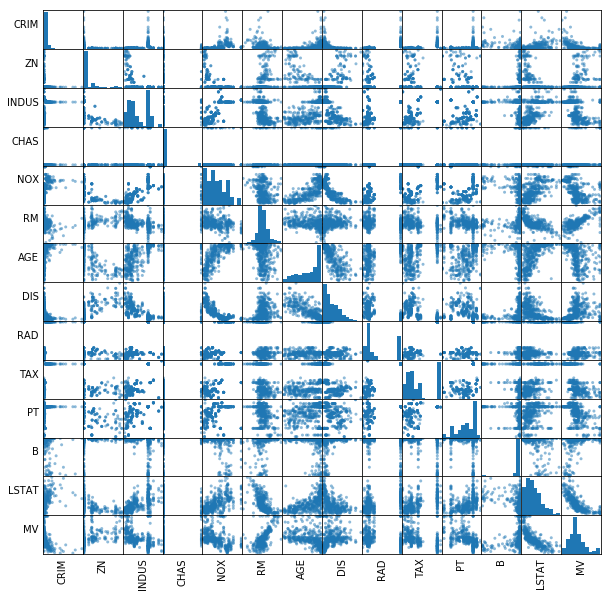

In [7]:
import pandas as pd

numeric_features = [t[0] for t in house_df.dtypes if t[1] == 'int' or t[1] == 'double']
sampled_data = house_df.select(numeric_features).sample(False, 0.8).toPandas()
axs = pd.scatter_matrix(sampled_data, figsize=(10, 10))
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [6]:
from pyspark.ml.feature import VectorAssembler

vectorAssembler = VectorAssembler(inputCols = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PT', 'B', 'LSTAT'], outputCol = 'features')
vhouse_df = vectorAssembler.transform(house_df)
vhouse_df.take(1)

[Row(CRIM=0.00632, ZN=18.0, INDUS=2.309999943, CHAS=0, NOX=0.537999988, RM=6.574999809, AGE=65.19999695, DIS=4.090000153, RAD=1, TAX=296, PT=15.30000019, B=396.8999939, LSTAT=4.980000019, MV=24.0, features=DenseVector([0.0063, 18.0, 2.31, 0.0, 0.538, 6.575, 65.2, 4.09, 1.0, 296.0, 15.3, 396.9, 4.98]))]

In [7]:
vhouse_df = vhouse_df.select(['features', 'MV'])
vhouse_df.show(3)

+--------------------+-----------+
|            features|         MV|
+--------------------+-----------+
|[0.00632,18.0,2.3...|       24.0|
|[0.027310001,0.0,...|21.60000038|
|[0.02729,0.0,7.07...|34.70000076|
+--------------------+-----------+
only showing top 3 rows



In [8]:
splits = vhouse_df.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

### Linear Regression

In [9]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol = 'features', labelCol='MV', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [-0.02381646354431101,0.02722185764525863,0.0,3.2800501464244807,-5.531548613196492,4.780306034575176,0.0,-0.748926484533982,0.0,0.0,-0.7222531715364013,0.010546269973726138,-0.5373341395178974]
Intercept: 14.65890007909873


#### Summarize the model over the training set and print out some metrics

In [10]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 4.880878
r2: 0.735738


RMSE measures the differences between predicted values by the model and the actual values. However, RMSE alone is meaningless until we compare with the actual "MV" value, such as mean, min and max. After such comparison, our RMSE looks pretty good.

In [11]:
train_df.describe().show()

+-------+------------------+
|summary|                MV|
+-------+------------------+
|  count|               349|
|   mean|22.783094576853863|
| stddev| 9.508325208920073|
|    min|               5.0|
|    max|              50.0|
+-------+------------------+



R squared at 0.74 indicates that in our model, approximate 74% of the variability in "MV" can be explained using the model. This is not bad.

In [12]:
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction","MV","features").show(5)

from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="MV",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+------------------+-----------+--------------------+
|        prediction|         MV|            features|
+------------------+-----------+--------------------+
|28.068843731329277|       22.0|[0.01096,55.0,2.2...|
|31.681341629398915|35.40000153|[0.01311,90.0,1.2...|
| 18.09053248877684|18.89999962|[0.0136,75.0,4.0,...|
|32.570317614249255|31.60000038|[0.01432,100.0,1....|
| 31.33694272711231|29.10000038|[0.01439,60.0,2.9...|
+------------------+-----------+--------------------+
only showing top 5 rows

R Squared (R2) on test data = 0.663723


In [13]:
test_result = lr_model.evaluate(test_df)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

Root Mean Squared Error (RMSE) on test data = 4.89433


In [14]:
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()

numIterations: 11
objectiveHistory: [0.49999999999999956, 0.43319911579026543, 0.23352384498945553, 0.20781137140169176, 0.1766048955865219, 0.17216023118288193, 0.1714600201458506, 0.17061409914581513, 0.169896212818038, 0.16974950026658042, 0.1695220630780412]
+--------------------+
|           residuals|
+--------------------+
|  -6.999588538602389|
|-4.86091131904231...|
| 0.17211682011706841|
|   9.921991563139635|
| -4.0243802176038415|
|  5.7120182722023145|
|   7.264289529967634|
|  2.8211210524380412|
| 0.12552108135977136|
|  -4.048334606880868|
|   6.727073368879548|
| -1.0905652504359686|
|   8.531002717025004|
|  -2.226605931262334|
| -1.0002435538421217|
|  -9.843574869101094|
|  -4.910335001456314|
|  2.8882127677131706|
| -3.8567794884959135|
|  -2.496729649423621|
+--------------------+
only showing top 20 rows



In [15]:
predictions = lr_model.transform(test_df)
predictions.select("prediction","MV","features").show()

+------------------+-----------+--------------------+
|        prediction|         MV|            features|
+------------------+-----------+--------------------+
|28.068843731329277|       22.0|[0.01096,55.0,2.2...|
|31.681341629398915|35.40000153|[0.01311,90.0,1.2...|
| 18.09053248877684|18.89999962|[0.0136,75.0,4.0,...|
|32.570317614249255|31.60000038|[0.01432,100.0,1....|
| 31.33694272711231|29.10000038|[0.01439,60.0,2.9...|
|38.172506412127674|42.29999924|[0.02177,82.5,2.0...|
|30.447373646089154|30.79999924|[0.027629999,75.0...|
|26.678134707422593|26.60000038|[0.02899,40.0,1.2...|
|30.398690967837823|31.20000076|[0.03049,55.0,3.7...|
| 33.75524119836187|34.90000153|[0.03359,75.0,2.9...|
|28.912058387407164|24.10000038|[0.034449998,82.5...|
| 24.45218648968526|19.39999962|[0.03466,35.0,6.0...|
|32.057226210868095|       28.5|[0.035020001,80.0...|
|29.799023912788364|       23.5|[0.035840001,80.0...|
|23.026323937087895|20.70000076|[0.037379999,0.0,...|
|27.538941501564796|22.89999

### Decision tree regression

In [16]:
from pyspark.ml.regression import DecisionTreeRegressor

dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'MV')
dt_model = dt.fit(train_df)
dt_predictions = dt_model.transform(test_df)
dt_evaluator = RegressionEvaluator(
    labelCol="MV", predictionCol="prediction", metricName="rmse")
rmse = dt_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 5.51665


### Feature Importance

In [18]:
train_df.take(1)

[Row(features=DenseVector([0.0063, 18.0, 2.31, 0.0, 0.538, 6.575, 65.2, 4.09, 1.0, 296.0, 15.3, 396.9, 4.98]), MV=24.0)]

In [17]:
dt_model.featureImportances

SparseVector(13, {0: 0.0496, 1: 0.0, 4: 0.0118, 5: 0.624, 6: 0.0005, 7: 0.1167, 8: 0.0044, 10: 0.013, 12: 0.1799})

In [20]:
house_df.take(1)

[Row(CRIM=0.00632, ZN=18.0, INDUS=2.309999943, CHAS=0, NOX=0.537999988, RM=6.574999809, AGE=65.19999695, DIS=4.090000153, RAD=1, TAX=296, PT=15.30000019, B=396.8999939, LSTAT=4.980000019, MV=24.0)]

The number of rooms is the most important feature to predict the house price.

### Gradient-boosted tree regression

In [40]:
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'MV', maxIter=10)
gbt_model = gbt.fit(train_df)
gbt_predictions = gbt_model.transform(test_df)
gbt_predictions.select('prediction', 'MV', 'features').show(5)

+------------------+-----------+--------------------+
|        prediction|         MV|            features|
+------------------+-----------+--------------------+
|27.770974306997353|       24.0|[0.00632,18.0,2.3...|
|  31.8725607595336|32.70000076|[0.01301,35.0,1.5...|
|26.050662475906574|23.10000038|[0.0187,85.0,4.15...|
| 49.91165024470532|       50.0|[0.020090001,95.0...|
|30.058521673343606|31.10000038|[0.02187,60.0,2.9...|
+------------------+-----------+--------------------+
only showing top 5 rows



In [41]:
gbt_evaluator = RegressionEvaluator(
    labelCol="MV", predictionCol="prediction", metricName="rmse")
rmse = gbt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 4.19795
